In [1]:
import numpy as np
import matplotlib.pyplot as plt

Explanation of Key Steps

    Age-dependent transitions

        We model the transition probabilities from “good” to the other states as changing slightly with age. In the code, transition_matrix(age) defines how the row for “good” evolves with age, while “medium” and “bad” are held constant for simplicity.

        In practice, you would fill in actual probabilities from your data or assumptions, ensuring each row sums to 1 and all entries are ≥0≥0.

    State- and Age-specific LTC probabilities

        The function ltc_probability(age, state) returns the probability that an individual in a given health state at a certain age becomes LTC-dependent. Again, the numbers here are just an example.

    Iterative Markov process

        We keep a vector p which tracks (pgood,pmedium,pbad)(pgood,pmedium,pbad). Initially, it is [0.7, 0.2, 0.1] at age 60.

        For each age, we calculate the average LTC probability ∑sps×LTC(a∣s)∑s​ps​×LTC(a∣s).

        Then we use the age-specific transition matrix to update the distribution for the next age: p = p @ P.

    Single curve

        We store these average probabilities in ltc_avgs and then plot them. That yields a single line showing how LTC risk evolves with age on average, taking into account the distribution across health states and the LTC probabilities for each state.

You can adapt this template to your own data for:

    Age- and state-specific transition matrices,

    Initial health-state distributions,

    LTC probabilities.

In [ ]:
# --- 1) AGE RANGE ---
ages = np.arange(60, 101)  # 60, 61, ..., 100

# --- 2) INITIAL DISTRIBUTION OF HEALTH STATES AT AGE 60 ---
# Suppose 70% are in 'good', 20% in 'medium', 10% in 'bad' at age 60
p = np.array([0.7, 0.2, 0.1])  # state order: [good, medium, bad]

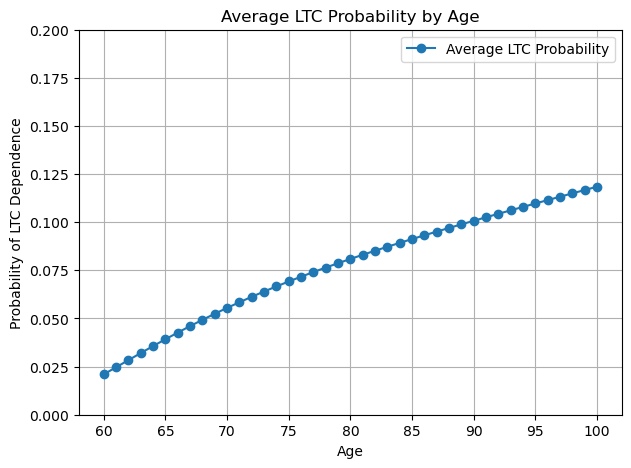

In [1]:
# --- 3) FUNCTIONS TO GET AGE-DEPENDENT TRANSITIONS AND LTC PROBS ---

def transition_matrix(age):
    """
    Returns a 3x3 transition matrix for the given age.
    Rows sum to 1. The row order is [good, medium, bad].
    This is just a toy example to illustrate the concept.
    """
    # For "good" row (index 0): let probabilities vary with age
    # so that as age increases, staying in good might decrease a bit,
    # while transitions to medium/bad might increase.
    p_good_to_good   = 0.88 - 0.002 * (age - 60)  # decreases slightly from 0.88 to ~0.80 by age 100
    p_good_to_medium = 0.10 + 0.001 * (age - 60)  # increases from 0.10 to ~0.14
    p_good_to_bad    = 1.0 - p_good_to_good - p_good_to_medium

    # For "medium" row (index 1): let's keep it simpler and constant
    p_med_to_good   = 0.05
    p_med_to_medium = 0.85
    p_med_to_bad    = 0.10

    # For "bad" row (index 2): also keep constant
    p_bad_to_good   = 0.01
    p_bad_to_medium = 0.05
    p_bad_to_bad    = 0.94

    P = np.array([
        [p_good_to_good,   p_good_to_medium,   p_good_to_bad],
        [p_med_to_good,    p_med_to_medium,    p_med_to_bad],
        [p_bad_to_good,    p_bad_to_medium,    p_bad_to_bad]
    ])
    return P

def ltc_probability(age, state):
    """
    Returns the probability of LTC dependence at a given age
    for a given health state (0=good, 1=medium, 2=bad).
    Another toy example with mild age-dependence:
    """
    if state == 0:  # good
        # e.g., grows from 0.01 at age 60 to 0.03 at age 100
        return 0.01 + 0.0005*(age - 60)
    elif state == 1:  # medium
        # e.g., from 0.03 at age 60 to 0.07 at age 100
        return 0.03 + 0.001*(age - 60)
    else:  # bad
        # e.g., from 0.08 at age 60 to 0.16 at age 100
        return 0.08 + 0.002*(age - 60)

# --- 4) ITERATE OVER AGES, UPDATE HEALTH STATE DISTRIBUTION, COMPUTE LTC ---

ltc_avgs = []  # will store average LTC probabilities
dist_history = [p.copy()]  # optional: store the distribution for inspection

for age in ages:
    # Compute the average LTC prob at this age:
    # LTC_avg(a) = sum_{state} p(state) * LTC_prob(age, state)
    ltc_prob = 0.0
    for s in range(3):  # s=0(good),1(medium),2(bad)
        ltc_prob += p[s] * ltc_probability(age, s)
    ltc_avgs.append(ltc_prob)

    # Update the distribution for next age (unless age==100, end of range)
    if age < 100:
        P = transition_matrix(age)
        p = p @ P
        dist_history.append(p.copy())

ltc_avgs = np.array(ltc_avgs)

# --- 5) PLOT THE SINGLE LINE OF AVERAGE LTC PROB BY AGE ---

plt.figure(figsize=(7,5))
plt.plot(ages, ltc_avgs, marker='o', label='Average LTC Probability')
plt.title('Average LTC Probability by Age')
plt.xlabel('Age')
plt.ylabel('Probability of LTC Dependence')
plt.ylim(0, 0.2)   # just to give a nice scale; adjust as needed
plt.grid(True)
plt.legend()
plt.show()


## 2) With survival

Overview of the Approach

    Keep track of “Alive fraction”: alive[a]alive[a] is the fraction of the original age-60 cohort still alive at age aa.

    Keep track of distribution among living health states:
    pa=(pagood, pamedium, pabad),
    pa​=(pagood​,pamedium​,pabad​),

    where these three components sum to 1 among survivors.

        Then the unconditional fraction of the entire original cohort in each health state at age aa is alive[a]×pasalive[a]×pas​.

    Compute LTC:

        Conditional LTC probability among survivors at age aa:
        LTC_among_survivors(a)  =  ∑s∈{good,medium,bad}pas  ×  pLTC(a∣s).
        LTC_among_survivors(a)=s∈{good,medium,bad}∑​pas​×pLTC​(a∣s).

        Unconditional probability of being LTC in the entire original cohort:
        LTC_unconditional(a)  =  alive[a]  ×  LTC_among_survivors(a).
        LTC_unconditional(a)=alive[a]×LTC_among_survivors(a).

This way, you can visualize how many are in LTC out of the entire original population (unconditional) or only among those still alive (conditional).

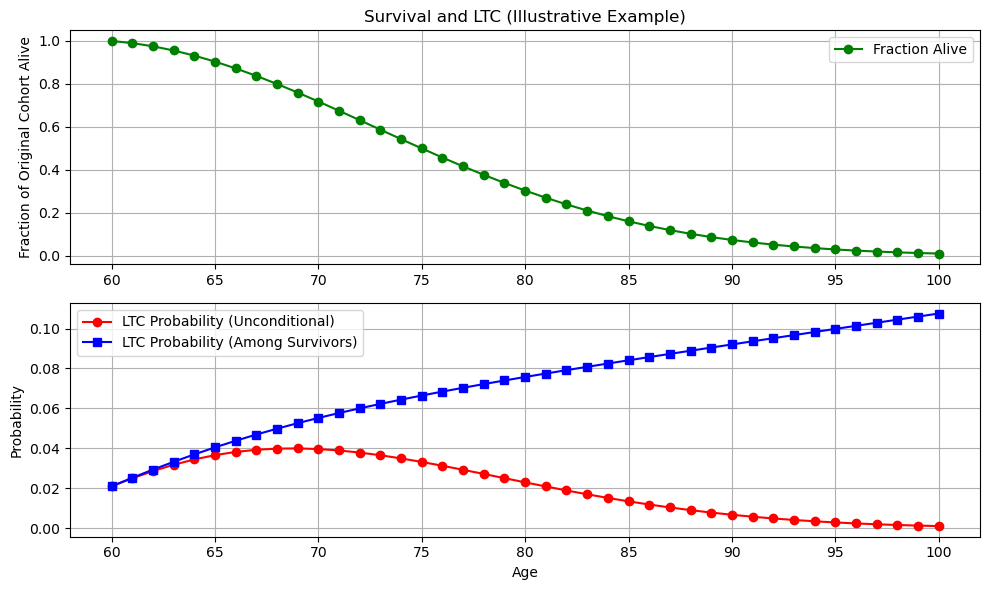

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------
# 1) AGE RANGE
# -------------------------
ages = np.arange(60, 101)  # 60, 61, ..., 100

# -------------------------
# 2) AGE-SPECIFIC SURVIVAL
# -------------------------
def survival_prob(age):
    """
    Probability that a living individual at age 'age'
    survives to age 'age+1'.
    This is just a toy illustration.
    """
    # E.g. at age 60, 99% survive to 61;
    # then linearly decreasing by 0.5% per year up to age 100
    # (so it becomes 0.99 - 0.005*(age - 60)).
    sp = 0.99 - 0.005 * (age - 60)
    return max(0.0, sp)

# -------------------------
# 3) STATE-SPECIFIC LTC PROB
# -------------------------
def ltc_probability(age, state):
    """
    Probability of LTC dependence for a person in a given health state
    at a given age. State is 0=good, 1=medium, 2=bad.
    Again, purely illustrative numbers.
    """
    if state == 0:  # good
        # e.g. from 1% at 60 to ~3% by 100
        return 0.01 + 0.0005 * (age - 60)
    elif state == 1:  # medium
        # from 3% at 60 to ~7% by 100
        return 0.03 + 0.001 * (age - 60)
    else:  # bad
        # from 8% at 60 to ~16% by 100
        return 0.08 + 0.002 * (age - 60)

# -------------------------
# 4) AGE-DEPENDENT TRANSITION AMONG HEALTH STATES
#    (Ignoring mortality here; we handle mortality separately)
# -------------------------
def transition_matrix(age):
    """
    Returns a 3x3 transition matrix among living states:
      rows = current state, columns = next state
      states = [good, medium, bad].
    Each row should sum to 1.
    """
    # Example: Let the 'good' row vary with age
    p_good_to_good   = 0.85 - 0.002 * (age - 60)  # slightly decreasing with age
    p_good_to_medium = 0.12 + 0.001 * (age - 60)
    p_good_to_bad    = 1.0 - p_good_to_good - p_good_to_medium

    # Keep 'medium' row constant (arbitrary example)
    p_med_to_good   = 0.05
    p_med_to_medium = 0.85
    p_med_to_bad    = 0.10

    # Keep 'bad' row constant (arbitrary example)
    p_bad_to_good   = 0.02
    p_bad_to_medium = 0.08
    p_bad_to_bad    = 0.90

    P = np.array([
        [p_good_to_good,   p_good_to_medium,   p_good_to_bad],
        [p_med_to_good,    p_med_to_medium,    p_med_to_bad ],
        [p_bad_to_good,    p_bad_to_medium,    p_bad_to_bad ]
    ])
    return P

# -------------------------
# 5) ITERATION OVER AGES
# -------------------------

# (a) INITIAL CONDITIONS
p = np.array([0.70, 0.20, 0.10])  # distribution among [good, medium, bad] at age=60
alive = 1.0  # 100% of the original cohort is alive at the start (age 60)

# We'll store time series in arrays:
alive_history = []
ltc_uncond_history = []      # Probability LTC in entire original cohort
ltc_cond_survivors_history = []  # Probability LTC among survivors only

for age in ages:
    # Record fraction alive at current age
    alive_history.append(alive)

    # Probability of LTC among survivors (weighted by the distribution p)
    ltc_cond = 0.0
    for s in range(3):
        ltc_cond += p[s] * ltc_probability(age, s)

    # Probability of LTC in the entire (original) cohort at age 'age'
    # = fraction alive * fraction LTC among those alive
    ltc_uncond = alive * ltc_cond

    ltc_cond_survivors_history.append(ltc_cond)
    ltc_uncond_history.append(ltc_uncond)

    # --- Update for next age ---
    # 1) Multiply 'alive' by the survival probability from age->age+1
    sp = survival_prob(age)
    new_alive = alive * sp

    # 2) Among those who survive, update distribution p with the Markov transition
    #    matrix for living states.
    P = transition_matrix(age)
    new_p = p @ P  # next year's distribution among living states

    # 3) If new_alive < something very small, we can break out or set distribution to 0
    if new_alive <= 1e-12:
        # Everyone is effectively dead
        alive = 0.0
        p = np.array([0.0, 0.0, 0.0])
    else:
        # Rescale distribution to sum to 1 among survivors
        # (In this model, we assume no one 'dies' inside these transitions,
        #  because mortality is handled separately by 'survival_prob'.)
        p = new_p / new_p.sum()
        alive = new_alive

# Convert to NumPy arrays for easier plotting
alive_history = np.array(alive_history)
ltc_uncond_history = np.array(ltc_uncond_history)
ltc_cond_survivors_history = np.array(ltc_cond_survivors_history)

# -------------------------
# 6) PLOTTING
# -------------------------

plt.figure(figsize=(10,6))

# (a) Plot fraction alive over time
plt.subplot(2,1,1)
plt.plot(ages, alive_history, 'g-o', label='Fraction Alive')
plt.title('Survival and LTC (Illustrative Example)')
plt.ylabel('Fraction of Original Cohort Alive')
plt.grid(True)
plt.legend(loc='best')

# (b) Plot LTC probabilities
plt.subplot(2,1,2)
plt.plot(ages, ltc_uncond_history, 'r-o', label='LTC Probability (Unconditional)')
plt.plot(ages, ltc_cond_survivors_history, 'b-s', label='LTC Probability (Among Survivors)')
plt.xlabel('Age')
plt.ylabel('Probability')
plt.grid(True)
plt.legend(loc='best')

plt.tight_layout()
plt.show()